In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134 (Winter 2024) 
    
## Collaboration Policy 

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *Owen Philliber* *Kevin Li*

In [2]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D\circ\Gamma)^TV \\
V^{\text{new}} &= V + 2\alpha (D\circ\Gamma)U \\
\Gamma = R - VU^T
\end{aligned}
$$

<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [3]:
import numpy as np
import pandas as pd

def update_G(R_, U_, V_):
    
    return R_ - V_@U_.T

def update_U(G_, U_, V_, alpha=0.01):
    
    return U_ + 2*alpha*np.nan_to_num(G_).T@V_

def update_V(G_, U_, V_, alpha=0.01):
    
    return V_ + 2*alpha*np.nan_to_num(G_)@U_

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [4]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [5]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [6]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G,U,V,alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [7]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [8]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [9]:
## TEST ##
output2['U'].shape

(5, 8)

In [10]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [11]:
## TEST ##
output2['V'].shape

(7, 8)

In [12]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [13]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [14]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [15]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [16]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

alt.VConcatChart(...)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

1. **Root Mean Square Error (RMSE) Over Iterations (Top Left):**
   - This plot shows the RMSE on a logarithmic scale as the optimization algorithm progresses over iterations.
   - Interpretation: A decreasing RMSE indicates that the model is improving in predicting the movie ratings. The logarithmic scale helps to appreciate changes when the error values become small. The smooth and consistent decline suggests the algorithm is steadily converging towards a solution.

2. **Maximum Residual Change Over Iterations (Top Right):**
   - This plot shows the maximum change in the residuals between successive iterations, also on a logarithmic scale.
   - Interpretation: The maximum residual change decreasing means that the updates to the user and item matrices are leading to smaller and smaller adjustments, indicating convergence. The residual changes should ideally approach zero, which would imply that subsequent iterations are not resulting in significant changes to the matrices.

3. **Maximum Update Over Iterations (Bottom):**
   - This plot shows the maximum update value applied to any entry in the matrices \( U \) or \( V \) at each iteration, on a logarithmic scale.

    1. **Initial Fluctuations:**
       - The initial large fluctuations are expected as the algorithm starts with initial guesses for the parameters, which could be far from optimal. The algorithm makes large adjustments to quickly move towards a better solution. This is common in the early stages of optimization, especially if the initial parameters are random or not close to the solution space.

    2. **Periodic Patterns:**
       - The periodic patterns of spikes could indeed suggest a component of the optimization algorithm that is designed to explore the parameter space more broadly. This is akin to simulated annealing or other algorithms that allow for temporary increases in the cost function to avoid local minima. If the optimization is using something like a cyclical learning rate, these patterns could also emerge as the learning rate varies, facilitating exploration and exploitation in the optimization landscape.

    3. **Convergence Behavior:**
       - As the algorithm continues to run, the decrease in the max update values indicates that the parameters are being refined, and the updates are becoming more nuanced as the optimization nears a minimum. This suggests that the algorithm is zeroing in on a stable set of parameters that provide a good fit to the data.

    4. **Potential Reset or Restart Mechanism:**
       - The sudden and periodic spikes could be indicative of a mechanism within the algorithm designed to prevent convergence to a poor local minimum. This could be an intentional feature of the algorithm to periodically "shake up" the parameters in a controlled way, which can be beneficial for finding a better overall solution.

    5. **Stabilization and Convergence:**
       - The final trend, where updates are consistently small, implies that the algorithm is stabilizing. This behavior is what we would hope to see as it implies that further iterations are only making marginal improvements to the fit of the model, and it suggests that the algorithm has effectively converged.

- In summary, the optimization algorithm shows a promising trajectory toward convergence, with initial large corrections, intermittent explorative updates, and eventual stabilization indicating fine-tuning of parameters. The periodic spikes suggest a sophisticated mechanism at play that helps the algorithm navigate the optimization landscape to avoid suboptimal solutions. The occasional spikes in the maximum update plot may warrant further investigation to ensure they are expected behavior and not a sign of instability in the optimization algorithm. It is also important to ensure that the learning rate (step-size \( \alpha \)) is not too high, as this could cause oscillations or divergence in the optimization process. If those spikes correspond to sudden jumps in RMSE or do not diminish over time, it may be necessary to adjust the learning rate or investigate the data for issues such as non-standardized inputs or outliers. combine these two paragraphs smoothly



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [17]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

In [18]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

/tmp/ipykernel_1207/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


alt.Chart(...)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

- The plot produced by the code is a density plot comparing the distribution of fitted ratings values ('fit') to the distribution of observed ratings values ('observed'). It visualizes how well the fitted values from the matrix factorization process match the observed ratings. Each sub-plot represents the distribution of ratings for a specific rating value (1 through 5). This is done by concatenating the fitted and observed ratings into a single DataFrame and then sampling 5000 data points from this combined distribution to create the density plots.
- When adding `counts=True` to the `transform_density` method in the Altair visualization library, the density estimation is normalized to show the raw count instead of the probability density. This means the y-axis will represent the count of samples within each bin of the x-axis value, instead of the probability density of the values.
- Without `counts=True`: The plot shows the probability density, allowing you to assess the shape of the distribution of fitted versus observed values. If the matrix factorization model is performing well, you would expect the distributions to be similar, indicating that the fitted values closely match the observed ratings.
- With `counts=True`: The plot will focus on the raw counts, which gives you an idea of the number of ratings at each level. This can help assess not only the shape of the distribution but also the absolute frequency of different ratings. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [19]:
predict = pd.concat([pd.DataFrame(Rhatbig.iloc[:,600].sort_values(ascending=False))\
            .rename(columns={601:'predicted'}),pd.DataFrame(Rbig.iloc[:,600]\
            .sort_values(ascending=False)).rename(columns={601:'observed'})],axis=1)\
            .sort_values(by=('rating','predicted'),ascending=False)\

recommend = predict[predict.iloc[:,1].isna()].head()
recommend


rating         
                                              predicted observed
movie id movie title                                            
1500     Santa with Muscles (1996)             4.932997      NaN
1467     Saint of Fort Washington, The (1993)  4.016834      NaN
408      Close Shave, A (1995)                 3.973421      NaN
216      When Harry Met Sally... (1989)        3.822423      NaN
194      Sting, The (1973)                     3.494979      NaN

Based on the result, I will recommend *Santa with Muscles (1996)*, *Saint of Fort Washington, The (1993)*, *Close Shave, A (1995)*,*When Harry Met Sally... (1989)* and *Sting, The (1973)* because those are the movies with the highest predicted ratings. 

In [20]:
predict.sort_values(by=('rating','observed'),ascending=False).head(20)

rating         
                                                        predicted observed
movie id movie title                                                      
181      Return of the Jedi (1983)                      -4.158753      5.0
132      Wizard of Oz, The (1939)                        3.297184      5.0
154      Monty Python's Life of Brian (1979)             2.927050      5.0
763      Happy Gilmore (1996)                            2.353348      5.0
179      Clockwork Orange, A (1971)                      3.008393      5.0
429      Day the Earth Stood Still, The (1951)           3.076847      5.0
173      Princess Bride, The (1987)                      3.147893      5.0
228      Star Trek: The Wrath of Khan (1982)             3.151069      5.0
1084     Anne Frank Remembered (1995)                    2.024942      5.0
201      Evil Dead II (1987)                             2.653988      5.0
168      Monty Python and the Holy Grail (1974)          4.223360      5.0
921      Farewell My Concubine (1993)                    1.846661      5.0
258      Contact (1997)                                  0.408124      5.0
250      Fifth Element, The (1997)                       2.584092      4.0
131      Breakfast at Tiffany's (1961)                   2.436451      4.0
1615     Warriors of Virtue (1997)                       2.490028      4.0
318      Schindler's List (1993)                         2.532389      4.0
109      Mystery Science Theater 3000: The Movie (1996)  2.543192      4.0
164      Abyss, The (1989)                               2.561561      4.0
284      Tin Cup (1996)                                  1.919205      4.0

Based on the information, it seems that user ID 601 highly rated a diverse range of movies. Some key observations are:

1. **Classic Films**: The user rated classic films such as "The Wizard of Oz" and "Day the Earth Stood Still" highly. Both are significant in film history for their storytelling and special effects.

2. **Sci-Fi and Fantasy**: There is a strong presence of science fiction and fantasy titles like "Star Trek: The Wrath of Khan," "Monty Python and the Holy Grail," and "The Princess Bride." This indicates a preference for films in these genres.

3. **Cult Classics and Comedies**: The list includes cult classics and comedies such as "Monty Python's Life of Brian" and "Evil Dead II," suggesting a taste for humor and perhaps unconventional movies.

4. **Serious Dramas**: Movies like "Schindler's List" indicate an appreciation for more serious, dramatic storytelling.

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

**Solution**

$$
\begin{aligned}
\frac{\partial}{\partial u_i} g(u_i, v_m) = -2(r_{mi} - v_m u_i^T)v_m + 2\lambda u_i \\
\frac{\partial}{\partial v_m} g(u_i, v_m) = -2(r_{mi} - v_m u_i^T)u_i + 2\lambda v_m \\
\frac{\partial}{\partial U} g(U, V) = -2R^T V + 2\lambda U \\
\frac{\partial}{\partial V} g(U, V) = -2R U + 2\lambda V \\
\Gamma = R - VU^T  \\
\end{aligned}
$$

$$
\begin{align*}
U^{\text{new}} &= U + 2\alpha (\Gamma^TV - \lambda U), \\
V^{\text{new}} &= V + 2\alpha(\Gamma U - \lambda V) \\ 
\end{align*}
$$

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [21]:
import numpy as np
import pandas as pd

def update_G_reg(R, U, V):
    return R - np.dot(V, U.T)

def update_U_reg(G, U, V, lam, alpha=0.01):
    return U + 2 * alpha * (np.dot(np.nan_to_num(G).T, V) - lam * U)

def update_V_reg(G, U, V, lam, alpha=0.01):
    return V + 2 * alpha * (np.dot(np.nan_to_num(G), U) - lam * V)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [22]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [23]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [24]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [25]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

In [26]:
import altair as alt

logscale = alt.Scale(type='log', base=10)
fig_updates = \
    alt.Chart(output_noreg['update'].iloc[:900,:])\
    .mark_line()\
    .encode(
        x='iteration:Q',
        y=alt.Y('max update:Q', scale=alt.Scale(type='log', domain=[0.0001, 300]))
    ).properties(
    title={'text': 'Non-regularized'}
)
fig_updates_reg = \
    alt.Chart(output_reg['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=alt.Scale(type='log', domain=[0.0001, 300]))
    ).properties(
    title={'text': 'Regularized'}
)

alt.vconcat(
    fig_updates | fig_updates_reg
)

alt.VConcatChart(...)

**Graphs of Max Update**:
- The max update plot for the non-regularized model shows more variability and higher peaks initially, which suggest larger updates to the parameters in the early iterations. This can be indicative of the model adjusting significantly as it learns the structure of the dataset.
- The regularized model's max update plot exhibits smoother transitions and fewer large updates. This implies that regularization is working as intended, imposing a penalty for large parameter values which typically results in more stable and possibly slower learning.
- In summary, The graphs of the max update values indicate the convergence behavior of the algorithm in both scenarios. In the non-regularized case, the max update values show more volatility and take longer to converge, suggesting that the model parameters are being updated significantly at each iteration, potentially leading to overfitting. In contrast, the regularized model shows a smoother and more stable convergence, suggesting that the regularization term is effectively penalizing large updates and helping to prevent overfitting.

In [27]:
long = lambda x: x.stack().reset_index()

Uhat5 = long(output_noreg['U']).rename(columns={0: 'affinity'})
Uhat6 = long(output_reg['U']).rename(columns={0: 'affinity'})

fig_Rhat = alt.Chart(Uhat5).mark_rect().encode(
    x=alt.X('k:O', axis=alt.Axis(tickSize=0, labels=False, title='k')),
    y=alt.Y('user id:O', axis=alt.Axis(title='User')),
    color=alt.Color('affinity:Q', scale=alt.Scale(scheme='lighttealblue', reverse=False, domain=[Uhat5['affinity'].min(), Uhat5['affinity'].max()])\
                    , legend=alt.Legend(title='affinity', tickCount=5)),
    tooltip=['user id', 'k', 'affinity']
).properties(
    width=500,
    height=300,
    title={'text': 'Non-regularized User Matrix'}
)
fig_Rhat_reg = alt.Chart(Uhat6).mark_rect().encode(
    x=alt.X('k:O', axis=alt.Axis(tickSize=0, labels=False, title='k')),
    y=alt.Y('user id:O', axis=alt.Axis(title='User')),
    color=alt.Color('affinity:Q', scale=alt.Scale(scheme='lighttealblue', reverse=False, domain=[Uhat6['affinity'].min(), Uhat6['affinity'].max()])\
                    , legend=alt.Legend(title='affinity', tickCount=5)),
    tooltip=['user id', 'k', 'affinity']
).properties(
    width=500,
    height=300,
    title={'text': 'Regularized User Matrix'}
)

alt.hconcat(fig_Rhat, fig_Rhat_reg)

alt.HConcatChart(...)

**Heatmaps of User Matrices**:
- The heatmap for the non-regularized user matrix \( \hat{U} \) shows more variation in the affinity values across users and latent features (denoted by 'k'). This could suggest a model that is more fitted to the data but potentially overfitted due to capturing noise.
- The heatmap for the regularized user matrix \( \hat{U}_{reg} \) appears more uniform and less variable, which is expected as regularization tends to shrink the values towards zero, preventing overfitting and encouraging simpler models.
- In short, the heatmaps of the user matrices provide a visual representation of the latent factors for each user. The non-regularized heatmap shows more variation in the affinity values, indicating a wider range of factor magnitudes, which could correspond to overfitting, where the model captures noise along with the underlying patterns. The regularized heatmap appears smoother with less variation in the affinities, indicating that the regularization term is smoothing out the factors, which likely leads to better generalization on unseen data.

**Overall Conclusion**

- These visual differences align with the concept of regularization, which adds a penalty to the loss function to constrain the magnitude of the model parameters. Regularization is known to promote simpler models that may generalize better to new data by preventing overfitting to the training data. The observed patterns in the max update graphs and heatmaps support this notion, with the regularized model showing more stability during training and a more homogeneous distribution of parameters.

- In conclusion, the evidence suggests that regularization has a stabilizing effect on the learning process, leading to user matrices that have less extreme values, which can be beneficial for the model's ability to generalize. The decision to use regularization should consider the model's performance on validation data, the complexity of the data, and the desired balance between bias and variance.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

keeping $K$ constant, different values of $\lambda$

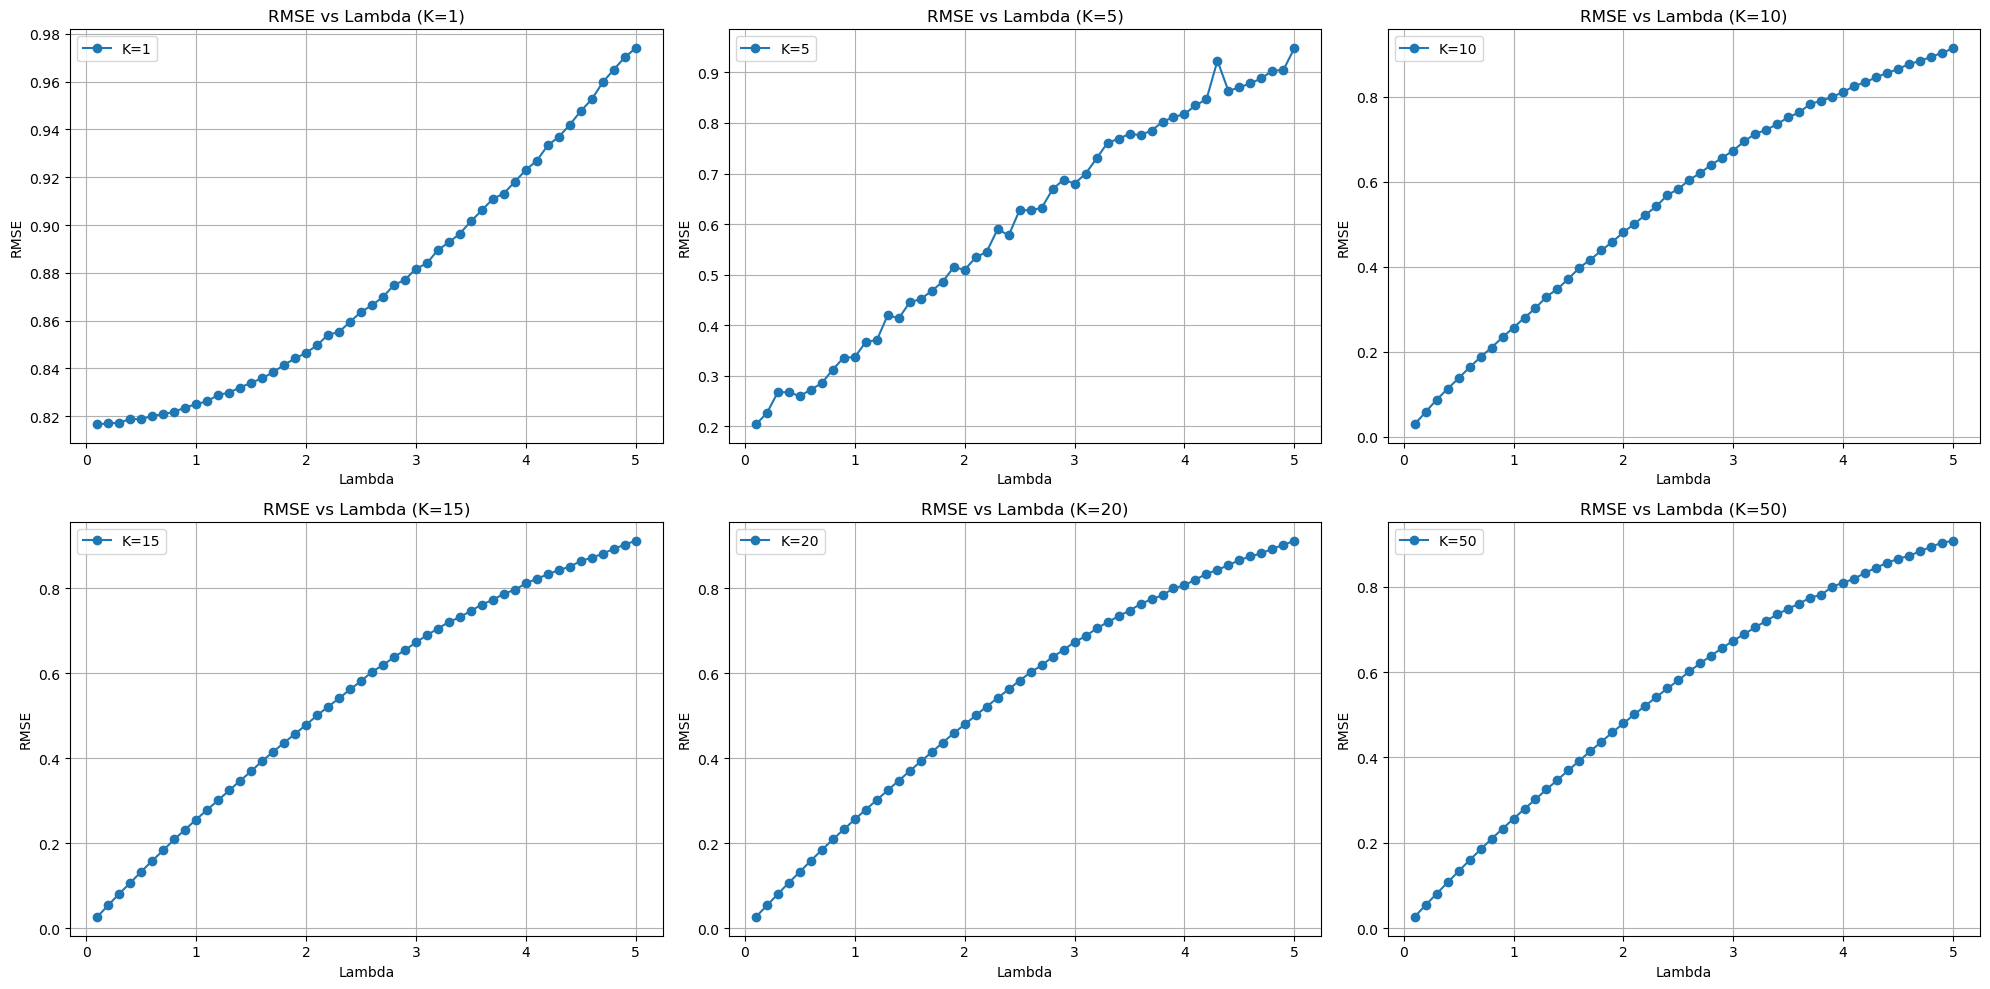

In [28]:
import numpy as np
import matplotlib.pyplot as plt

k_values = [1, 5, 10, 15, 20, 50]
lambda_values = np.arange(0.1, 5.1, 0.1)  # 0.1 to 5 inclusive, with a step of 0.1

# Create a figure for the subplots
# 5 subplots in total, arranging in 2 rows and 3 columns to fit all
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()


# Loop through each K value and create a subplot for each
for index, K in enumerate(k_values):
    # Compute RMSE for each lambda value at the current K
    rmse_values = [compute_UV_reg(Rsmall, K=K, lam=lam_value, alpha=0.001)['rmse'].iloc[-1]['rmse'] for lam_value in lambda_values]


    # Plot the trend of RMSE for different lambda values at the current K
    ax = axes[index]  # Get the corresponding subplot axis
    ax.plot(lambda_values, rmse_values, marker='o', label=f'K={K}')
    ax.set_title(f'RMSE vs Lambda (K={K})')
    ax.set_xlabel('Lambda')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True)

# If there are more axes than K values, turn off the extra ones
for i in range(len(k_values), len(axes)):
    axes[i].axis('off')

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()


The plots show that as the value of lambda increases, the RMSE also increases for all values of K that are kept constant. This suggests that as we increase the regularization strength, the model becomes less flexible and possibly too simplistic to capture the complexities of the data, hence the increase in error.

There is a significant difference in the RMSE for small values of K (K=1) compared to large values of K (K=50) across different lambda values. For small K, the model is likely to be very simplistic, which might not capture all the complexities of the data, thus potentially leading to a higher RMSE due to bias. On the other hand, a large K allows the model to capture more details of the data, which can lead to a lower RMSE if the model does not overfit.

However, it's also important to note that increasing K comes with the risk of overfitting, especially if there isn't enough data to support the additional complexity, or if the increase in K does not come with a corresponding adjustment in lambda to control overfitting.

Regularization is a technique used to prevent overfitting by penalizing larger values of the parameters. However, when regularization is too strong (lambda is too high), it can lead to underfitting where the model is not able to learn enough from the data. This is likely the reason for the increase in RMSE with higher lambda values. The model is penalizing the complexity so much that it loses the ability to fit the training data well, which in turn affects its performance on the validation or test data, resulting in higher RMSE values.

The trend is consistent across different values of K, which means that the effect of lambda on the model's performance is somewhat independent of the number of latent factors in this case. It would be beneficial to choose a lambda that balances the trade-off between bias and variance to achieve the lowest possible RMSE.

keeping $\lambda$ constant, different values of $K$

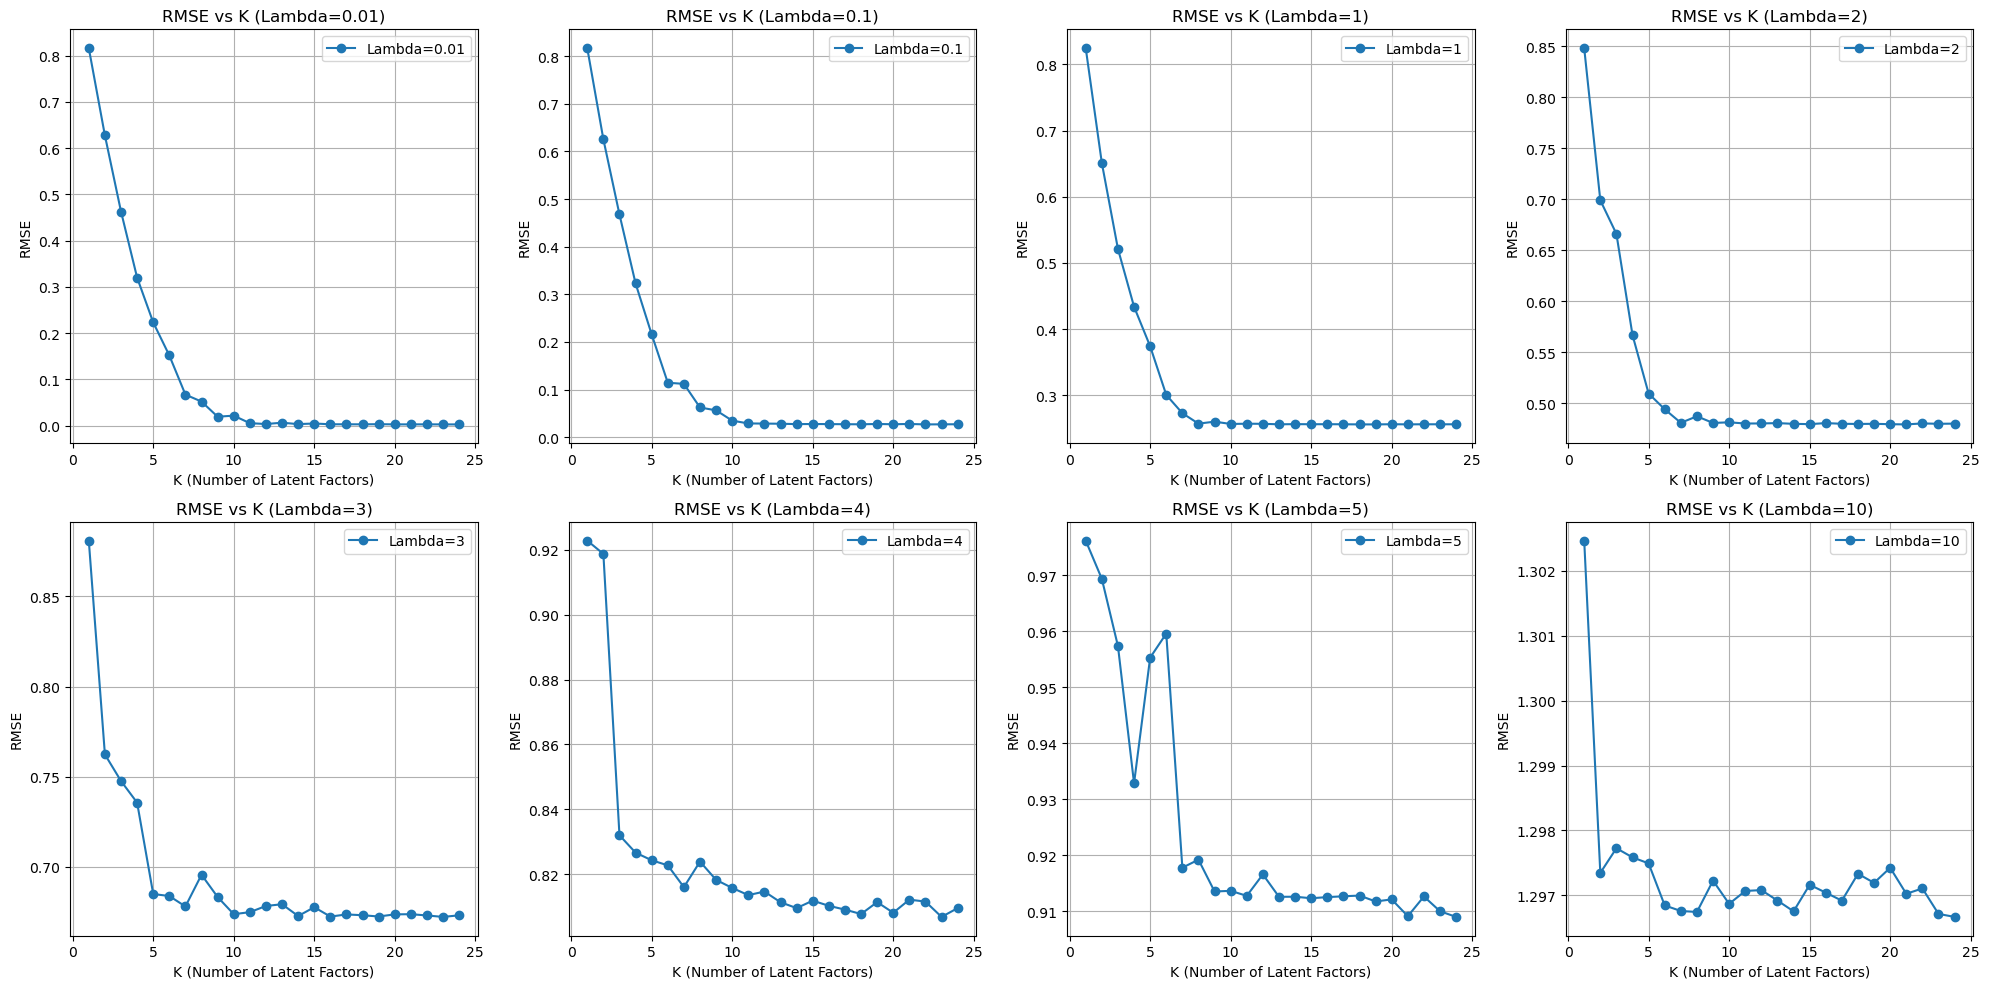

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming compute_UV_reg is defined elsewhere and Rsmall is available
# Define the lambda values and K range
lambda_values = [0.01, 0.1, 1, 2, 3, 4, 5,10]
k_values = np.arange(1, 25)

# Create a figure for the subplots
# Since we want 4 plots in the top row, we set the figure width larger
plt.figure(figsize=(20, 10))

# Loop through each lambda value and create a subplot for each
for index, lam in enumerate(lambda_values):
    # Compute RMSE for each K value at the current lambda
    rmse_values = [compute_UV_reg(Rsmall, K=k, lam=lam, alpha=0.001)['rmse']['rmse'].iloc[-1] for k in k_values]
    
    # Determine the position of the subplot
    if index < 4:  
        plt.subplot(2, 4, index + 1)
    else:  
        plt.subplot(2, 4, index + 1)  # +2 to leave an empty space under the first plot in row 1

    # Create a subplot
    plt.plot(k_values, rmse_values, marker='o', label=f'Lambda={lam}')
    plt.title(f'RMSE vs K (Lambda={lam})')
    plt.xlabel('K (Number of Latent Factors)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()


Looking at the plots I've generated, I can see that the RMSE generally decreases as I increase the number of latent factors K, particularly when K is small. This trend suggests that a larger K helps my model to better capture the variance in the data. However, the benefit of adding more latent factors seems to taper off as K gets larger, which aligns with the idea that there's a point at which additional complexity doesn't significantly improve my model's performance.

When I hold λ constant and vary K, I’m basically adjusting how complex my model can get without changing how much I’m penalizing that complexity. As K goes up, my model has the potential to overfit unless I also adjust λ to keep a good balance.

The difference between a small λ (like 0.01) and a large λ (like 10) is quite stark. A small λ means there's barely any regularization, so my model can fit the data very closely—but potentially too closely, which can lead to overfitting. On the other hand, a large λ puts a strong penalty on the magnitude of the parameters in my model, risking underfitting because my model could end up being too simple.

With λ set to 10, I can observe that the RMSE is relatively high across all K values, implying that the regularization might be too strict, preventing the model from capturing the data's structure well, resulting in a higher error.

From what I’ve learned, the sweet spot for K and λ is essential to avoid both underfitting and overfitting. Cross-validation comes in handy for this, as it lets me evaluate how well my model does on data it hasn’t seen before, showing me how well it might perform in the real world.

**Selecting appropriate values for $K$ and $\lambda$**

In [30]:
import numpy as np
from sklearn.model_selection import KFold

def cross_validate_UV_reg(Rdf, K_range, lambda_range, alpha=0.001, max_iteration=5000, diff_thr=1e-3, n_folds=5):
    best_rmse = float('inf')
    best_K = None
    best_lambda = None

    R = Rdf.values
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for K in K_range:
        for lam in lambda_range:
            rmse_sum = 0
            for train_index, test_index in kf.split(R):
                R_train, R_test = R[train_index], R[test_index]
                R_train_df = pd.DataFrame(R_train, index=Rdf.index[train_index], columns=Rdf.columns)

                output = compute_UV_reg(R_train_df, K=K, lam=lam, alpha=alpha, max_iteration=max_iteration, diff_thr=diff_thr)
                U, V = output['U'], output['V']
                R_pred = np.dot(V, U.T)

                # Add missing rows to R_pred
                R_pred = np.vstack([R_pred, np.zeros((R.shape[0] - R_pred.shape[0], R_pred.shape[1]))])

                rmse_sum += rmse(R_test - R_pred[test_index])

            avg_rmse = rmse_sum / n_folds

            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_K = K
                best_lambda = lam

    print(f"Best K: {best_K}, Best Lambda: {best_lambda}, Best RMSE: {best_rmse}")

    return best_K, best_lambda

In [31]:
np.random.seed(134)  # set seed for reproducibility

# K_range = [1,5,10,15,20]
# lambda_range = [0.1,0.5,1,2,3,4,5]
K_range = [5,10,15,20] 
lambda_range = np.arange(0.5, 5.1, 0.5).tolist()

best_K, best_lambda = cross_validate_UV_reg(Rsmall, K_range, lambda_range)

Best K: 5, Best Lambda: 3.5, Best RMSE: 1.8286313926130915


**Intepretation**

In this script, I've implemented a function `cross_validate_UV_reg` which is designed to help me find the best combination of the hyperparameters \( K \) and \( \lambda \) for my matrix factorization-based recommendation algorithm. Here's what I did:

1. I defined a function that takes as input my dataset `Rdf`, a range of values for \( K \) and \( \lambda \), a learning rate `alpha`, the maximum number of iterations `max_iteration`, a convergence threshold `diff_thr`, and the number of cross-validation folds `n_folds`.

2. I set up my function to iterate over each combination of \( K \) and \( \lambda \), performing cross-validation using the K-Fold method provided by scikit-learn with `n_folds` splits, shuffling the data, and setting a random state for reproducibility.

3. For each fold, I split my data into a training set and a test set. I used these subsets to fit my matrix factorization model and then generate predictions for the test set.

4. After making predictions, I filled in any missing values in the predicted ratings matrix with zeros to ensure it matched the shape of the actual ratings matrix.

5. I calculated the RMSE for each test set to evaluate the performance of the model with the current hyperparameters. I then averaged the RMSEs over all folds to get an overall performance measure for the current \( K \) and \( \lambda \) combination.

6. If the averaged RMSE was lower than the best RMSE found so far, I updated my best parameters to the current \( K \) and \( \lambda \), along with the best RMSE.

7. After evaluating all combinations, I returned the best \( K \) and \( \lambda \) that gave me the lowest average RMSE across all folds.

By using this approach, I've made sure to comprehensively evaluate the performance of different hyperparameter combinations, enabling me to select the most effective ones. It's a systematic method to fine-tune my recommendation system for better accuracy.

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

I get some help from Gia for 3a during her office hour

In [32]:
import numpy as np
import pandas as pd

# Loading rantings_stacked.pkl
np.random.seed(134) # set seed for tests
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()

# add some movies
movie_id = np.unique(np.concatenate([np.array(Rsmall.index.get_level_values('movie id')), np.arange(134, 235)])) - 1

user_id_ls = []
for i in range(1,Rbig.shape[1]):
    na_count = Rbig.iloc[movie_id, Rbig.columns.get_level_values('user id') == i].isna().sum().values[0] # movi
    if na_count < 134:
        user_id_ls.append(i)
user_id = np.unique(np.concatenate((user_id_ls,Rsmall.columns.get_level_values('user id'))))
user_id = user_id - 1



# new medium size R
Rmedium = Rbig.iloc[movie_id, user_id]


output = compute_UV_reg(Rmedium, K = 5, lam = 3.5, alpha = 0.001) 
Uhat = output['U'].to_numpy()
Uhat_std = (Uhat - Uhat.mean (axis=0)) / Uhat.std(axis=0)
Vhat = output['V'].to_numpy()
Vhat_std = (Vhat - Vhat.mean(axis=0)) / Vhat.std(axis=0)
UVstd = np.concatenate([Uhat_std, Vhat_std])

In [33]:
Rmedium

rating                         \
user id                                         1    2    3   4   5    6     
movie id movie title                                                         
82       Jurassic Park (1993)                   5.0  NaN  NaN NaN NaN  NaN   
97       Dances with Wolves (1990)              3.0  NaN  NaN NaN NaN  NaN   
111      Truth About Cats & Dogs, The (1996)    5.0  4.0  NaN NaN NaN  2.0   
132      Wizard of Oz, The (1939)               4.0  NaN  NaN NaN NaN  5.0   
134      Citizen Kane (1941)                    4.0  NaN  NaN NaN NaN  5.0   
...                                             ...  ...  ...  ..  ..  ...   
268      Chasing Amy (1997)                     5.0  NaN  3.0 NaN NaN  3.0   
475      Trainspotting (1996)                   NaN  NaN  NaN NaN NaN  5.0   
496      It's a Wonderful Life (1946)           NaN  NaN  NaN NaN NaN  4.0   
742      Ransom (1996)                          NaN  NaN  NaN NaN NaN  NaN   
748      Saint, The (1997)                      NaN  NaN  NaN NaN NaN  NaN   

                                                                 ...       \
user id                                       7    8   9    10   ...  933   
movie id movie title                                             ...        
82       Jurassic Park (1993)                 3.0  5.0 NaN  4.0  ...  3.0   
97       Dances with Wolves (1990)            5.0  NaN NaN  NaN  ...  2.0   
111      Truth About Cats & Dogs, The (1996)  NaN  NaN NaN  NaN  ...  NaN   
132      Wizard of Oz, The (1939)             5.0  NaN NaN  5.0  ...  3.0   
134      Citizen Kane (1941)                  4.0  NaN NaN  5.0  ...  NaN   
...                                           ...  ...  ..  ...  ...  ...   
268      Chasing Amy (1997)                   3.0  NaN NaN  NaN  ...  NaN   
475      Trainspotting (1996)                 NaN  NaN NaN  4.0  ...  2.0   
496      It's a Wonderful Life (1946)         5.0  NaN NaN  5.0  ...  NaN   
742      Ransom (1996)                        NaN  NaN NaN  NaN  ...  NaN   
748      Saint, The (1997)                    NaN  NaN NaN  NaN  ...  NaN   

                                                                            \
user id                                       934  935  936  937  938  939   
movie id movie title                                                         
82       Jurassic Park (1993)                 4.0  NaN  NaN  NaN  NaN  NaN   
97       Dances with Wolves (1990)            4.0  NaN  NaN  NaN  NaN  NaN   
111      Truth About Cats & Dogs, The (1996)  NaN  NaN  4.0  NaN  5.0  NaN   
132      Wizard of Oz, The (1939)             4.0  NaN  NaN  NaN  NaN  NaN   
134      Citizen Kane (1941)                  4.0  NaN  NaN  NaN  NaN  NaN   
...                                           ...  ...  ...  ...  ...  ...   
268      Chasing Amy (1997)                   NaN  NaN  4.0  1.0  NaN  NaN   
475      Trainspotting (1996)                 NaN  NaN  5.0  NaN  NaN  NaN   
496      It's a Wonderful Life (1946)         NaN  NaN  NaN  NaN  NaN  NaN   
742      Ransom (1996)                        NaN  5.0  NaN  NaN  3.0  5.0   
748      Saint, The (1997)                    NaN  NaN  2.0  NaN  2.0  NaN   

                                                             
user id                                       940  941  942  
movie id movie title                                         
82       Jurassic Park (1993)                 4.0  NaN  NaN  
97       Dances with Wolves (1990)            NaN  NaN  5.0  
111      Truth About Cats & Dogs, The (1996)  NaN  NaN  NaN  
132      Wizard of Oz, The (1939)             NaN  NaN  NaN  
134      Citizen Kane (1941)                  NaN  NaN  NaN  
...                                           ...  ...  ...  
268      Chasing Amy (1997)                   NaN  NaN  NaN  
475      Trainspotting (1996)                 NaN  4.0  NaN  
496      It's a Wonderful Life (1946)         NaN  NaN  5.0  
742      Ransom (1996)              

In [34]:
from sklearn.cluster import AgglomerativeClustering, KMeans 
from sklearn.preprocessing import StandardScaler

# Apply hierarchical clustering
hierarchical_clustering = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical_clustering.fit_predict(UVstd)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(UVstd)

print("Hierarchical Clustering:")
print(hierarchical_labels)

print("\nk-means Clustering:")
print(kmeans_labels)

Hierarchical Clustering:
[1 3 2 ... 3 1 0]

k-means Clustering:
[3 4 4 ... 0 2 1]


In [35]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

hierarchical_silhouette = silhouette_score(UVstd, hierarchical_labels, metric= 'euclidean')
kmeans_silhouette = silhouette_score(UVstd, kmeans_labels, metric='euclidean')
print(f"Silhouette Score for Hierarchiçal Clustering: {hierarchical_silhouette}")
print(f"Silhouette Score for KMeans Clustering: {kmeans_silhouette}")

hierarchical_calinski_harabasz = calinski_harabasz_score(UVstd, hierarchical_labels)
kmeans_calinski_harabasz = calinski_harabasz_score(UVstd,kmeans_labels)
print(f"\nCalinski-Harabasz Index for Hierarchical Clustering: {hierarchical_calinski_harabasz}")
print(f"Calinski-Harabasz Index for KMeans Clustering: {kmeans_calinski_harabasz}")

hierarchical_davies_bouldin = davies_bouldin_score(UVstd, hierarchical_labels)
kmeans_davies_bouldin = davies_bouldin_score(UVstd, kmeans_labels)
print(f"\nDavies-Bouldin Index for Hierarchical Clustering: {hierarchical_davies_bouldin}")
print(f"Davies-Bouldin Index for KMeans Clustering: {kmeans_davies_bouldin}")

Silhouette Score for Hierarchiçal Clustering: 0.16223965404510354
Silhouette Score for KMeans Clustering: 0.20466567904664723

Calinski-Harabasz Index for Hierarchical Clustering: 190.6295238343668
Calinski-Harabasz Index for KMeans Clustering: 236.08700732718106

Davies-Bouldin Index for Hierarchical Clustering: 1.7570826612617219
Davies-Bouldin Index for KMeans Clustering: 1.5293815882745723


**Conclusion**
- In assessing our clustering performance for the concatenated matrix UVstd, we employed three well-established metrics. The Silhouette Score assesses the cohesion and separation of clusters; the Calinski-Harabasz Index measures the dispersion ratio between and within clusters, emphasizing cluster distinction; and the Davies-Bouldin Index compares the average similarity within clusters, where lower values indicate better clustering.
    - The **Silhouette Score** is a crucial metric when the aim is to delineate clusters with clear boundaries and little overlap. Within our dataset, this score indicates that KMeans clustering offers a slightly more defined separation of clusters, with a score of 0.2047 compared to the Hierarchical clustering score of 0.1622. This suggests that in our user or movie clusters, members are more alike to each other and more distinct from other clusters, which is essential in providing targeted recommendations in a movie recommendation system.
    - The **Calinski-Harabasz Index** emphasizes the ratio of between-cluster dispersion to within-cluster dispersion, indicating the distinctness and separation of clusters. The KMeans clustering presents a higher Calinski-Harabasz Index of 236.087 relative to Hierarchical clustering's 190.6295. This metric shows us that the KMeans approach tends to form clusters where movies represent more diverse options that could cater to varying user preferences, and each cluster stands out more clearly from the others.
    - Conversely, the **Davies-Bouldin Index** reflects the average 'similarity' between clusters by comparing the distance between clusters with the sizes of the clusters themselves. For movie recommendations, a lower Davies-Bouldin score is more favorable, as it would indicate clusters are well-separated and internally homogeneous. KMeans clustering has a lower Davies-Bouldin score (1.5294) than Hierarchical clustering (1.7571), implying that within KMeans clusters, movies are more closely related to each other, thus potentially offering a more coherent set of recommendations to users.
- Each metric underscores different aspects of the clustering results, and in this scenario, all three metrics suggest that KMeans clustering is slightly better suited for our objectives. The separation and definition of clusters as measured by the Silhouette Score, along with the distinctness of clusters indicated by the Calinski-Harabasz Index and the comparative homogeneity within clusters from the Davies-Bouldin Index, collectively support the use of KMeans for creating distinct and relevant movie recommendations. In general, the higher **Silhouette Score** and **Calinski-Harabasz Index**, along with a lower **Davies-Bouldin Index**, suggest that the KMeans clustering offers clusters with more internal consistency and better distinction from each other, which is ideal for the recommendation system we aim to build.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [36]:
# install umap
# !pip install umap-learn

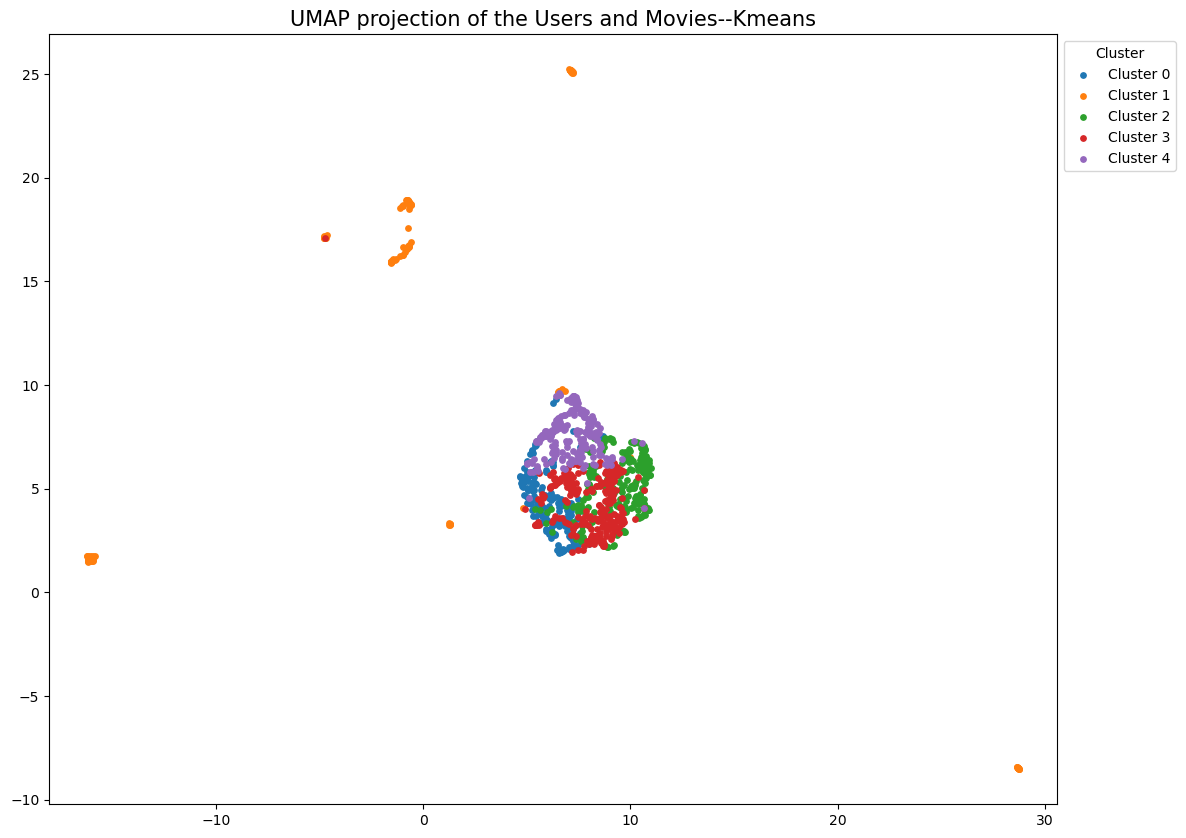

In [37]:
import umap.umap_ as umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(134) # set seed for tests

# Initialize UMAP and transform the data
reducer = umap.UMAP()
embedding = reducer.fit_transform(UVstd)

# Get user ids and movie titles from Rmedium for the index
user_id = Rmedium.columns.get_level_values('user id').to_numpy()
movie_title = Rmedium.index.get_level_values('movie title').to_numpy()
user_movie_index = np.concatenate([user_id, movie_title])
embedding_df = pd.DataFrame(embedding, index=user_movie_index)

# Visualization with legends
plt.figure(figsize=(13, 10))

# Get unique labels
unique_labels = np.unique(kmeans.labels_)

# Plot each cluster
for i in unique_labels:
    # Select only data points with the target label for this iteration
    indices = np.where(kmeans.labels_ == i)
    current_embedding = embedding[indices]
    plt.scatter(
        current_embedding[:, 0], 
        current_embedding[:, 1], 
        s=15,
        color=sns.color_palette()[i],
        label=f'Cluster {i}'
    )

# Set aspect of the plot and add title
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Users and Movies--Kmeans', fontsize=15)

# Add the legend outside of the plot
plt.legend(title='Cluster', bbox_to_anchor=(1, 1), loc='upper left')

# Display the plot
plt.show()


The UMAP projection shows clusters of data points in a two-dimensional space, which are color-coded to represent different clusters identified by the K-means algorithm. In the projection, the clusters seem to be well-separated, especially the main cluster at the bottom of the plot, which shows a grouping of data points with distinct colors indicating different clusters. There is clear space between most of the clusters, suggesting that the UMAP algorithm has managed to preserve the structure of the high-dimensional data in the reduced two-dimensional space.

However, there are a few data points scattered at a distance from the main cluster. These could be outliers or could represent smaller, less dense clusters. It's not unusual for dimensionality reduction techniques like UMAP to project outliers quite far from the denser regions. For instance, Cluster 1 appears isolated from the others, it's likely that this group represents users or movies (depending on what was clustered) that are very different from the rest in terms of their features. 

Overall, the UMAP projection appears consistent in the sense that there is a clear distinction between different clusters, as evidenced by the concentration of colors in certain areas of the plot. The consistency of cluster representation in the projection indicates that the underlying structure of the data is being captured effectively by UMAP, which in turn facilitates the interpretation of clusters formed by the KMeans algorithm.

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)